In [59]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from scipy.stats import beta as betadist
from scipy.special import beta, betainc
from scipy.integrate import quad as integrate
from numpy import sqrt
from numpy import vectorize as Vectorize
from math import asin
plt.rcParams['figure.figsize'] = (10, 5)
np.set_printoptions(linewidth=100)

# Generate simulation data

In [46]:
def generate_data(I = 100, k = random.uniform(0, 8)):
    Xi = []
    Yi = []
    ci = []
    ri = []
    for i in range(I):
        ci.append(random.random())
        ri.append(math.exp(random.random()))
        li = ci[-1] - ri[-1]
        mi = ci[-1] + ri[-1]
        Xi.append([li, mi])
        Yi.append([li + k, mi + k])
    ci_dash = [e + k for e in ci]
    return Xi, Yi, ci, ri, ci_dash, k              

In [91]:
Xi, Yi, c1, r1, c2, k = generate_data( k=1.1)
r2 = r1

ci_joined = c1 + c2
ri_joined = r1 + r2 

## Quantile Functions and Mallows Distances

In [48]:
def Qunif(t, c, r):
    assert (t>0 and t<1), "t must be in [0,1]"
    return (c-r + 2*t*r)

In [49]:
def QTri(t, c, r, m):
    assert (t>0 and t<1), "t must be in [0,1]"
    assert (m>c-r and m<c+r), "m must be in [c-r,c+r]"
    thresh = (m-c+r)/(2*r)
    if (t <= thresh):
        Q = c-r + sqrt(2*r*(m-c+r)*t)
    else:
        Q = c+r - sqrt(2*r*(c+r-m)*(1-t))
    return Q

# Mean quantile function
def mQTri(t,c,r,a,b):
    assert (a>=0 and b>=0), "a and b must be positive"
    if (a==1 and b==1):
        part1 = 2*r*t+c-r
        part2 = 4/3.*r*(sqrt(t) - sqrt(1-t) - t**2 + (1-t)**2)
    else:
        part1 = 2*r * betadist.pdf(t,a,b) + c - r
        part2 = 2*r / beta(a,b) * ( sqrt(t) * ( beta(a+1/2,b) - betainc(a+1/2,b,t)  ) - sqrt(1-t) * betainc(a,b+1/2,t) )
    return part1 + part2    

In [50]:
#
#
# Mallows distances
#
#

# Assume the 1st interval is given by [c1-r1, c1+r1]
# Assume the 2nd interval is given by [c2-r2, c2+r2]


##
## Assume the data are uniformly distributed over the 1st interval
## Assume the data are uniformly distributed over the 2nd interval
##

def MalUnifUnif(c1,r1,c2,r2):
    return (c1 - c2)**2 + 1./3*(r1-r2)**2

##
## Assume the data are uniformly distributed over the 1st interval
## Assume the data are triangular distributed over the 2nd interval
##
def MalUnifTri(c1,r1,c2,r2,m2):
    assert (m2>(c2-r2) and m2<(c2+r2)), "Mode m2 must be within [c2-r2,c2+r2]"
    val1 <- c1-c2-r1+r2
    val2 <- c1-c2-r1-r2
    pt1 <- 4/3.*r1**2 + 2 * val2*r1 + val1**2 / (2*r2) * (m2-c2+r2)
    pt2 <- val2**2 / (2*r2) * (c2-m2+r2)
    pt3 <- (m2-c2+r2)**2 * (r1 - 2/3.*val1)/r2
    pt4 <- (c2-m2+r2)**2 * (4/3.*r1 + 2/3.*val2)/r2
    pt5 <- (1/(4*r2) -2*r1/(5*r2**2)) * ( (m2-c2+r2)**3 + (c2-m2+r2)**3 )
    return sqrt(pt1 + pt2 + pt3 + pt4 + pt5)

##
## Assume the data are triangular distributed over the 1st interval
## Assume the data are triangular distributed over the 2nd interval
##
def MalTriTri(c1,r1,m1,c2,r2,m2):
    assert (m1>(c1-r1) and m1<(c1+r1)), "Mode m1 must be within [c1-r1,c1+r1]"
    assert (m2>(c2-r2) and m2<(c2+r2)), "Mode m2 must be within [c2-r2,c2+r2]"
    Index = ( (m1-c1)/r1 <= (m2-c2)/r2 )
  
    part0 = (c1-c2)**2 + 1/6.*((r1-r2)**2 + (m1-c1)**2 + (m2-c2)**2) - 5/3.*r1*r2
    if (Index):
        pt1A = c1-c2+r2
        pt1B = c1-c2+r1
        pt2 = (5 - (m1-c1)/r1)
        pt3 = (5 + (m2-c2)/r2)
        part4 = sqrt(r1*r2*(c1-m1+r1)*(m2-c2+r2))/2*(asin((m2-c2)/r2) - asin((m1-c1)/r1))
    else:
        pt1A = c1-c2-r2
        pt1B = c1-c2-r1    
        pt2 = (5 - (m2-c2)/r2)
        pt3 = (5 + (m1-c1)/r1)
        part4 = sqrt(r1*r2*(c2-m2+r2)*(m1-c1+r1))/2*(asin((m1-c1)/r1) - asin((m2-c2)/r2))
        
    part1 = 2*(m1-c1)*pt1A/3 - 2*(m2-c2)*pt1B/3
    part2 = sqrt(r1*r2*(m1-c1+r1)*(m2-c2+r2))/6 * pt2
    part3 = sqrt(r1*r2*(c1-m1+r1)*(c2-m2+r2))/6 * pt3
    return sqrt(part0 + part1 + part2 + part3 + part4)

In [60]:
#
#
# Mean Mallows distances
#
#

# Assume the 1st interval is given by [c1-r1, c1+r1]
# Assume the 2nd interval is given by [c2-r2, c2+r2]
#
# Method 1: compute the Mallows distance using mean quantile functions
# Method 2: compute the mean of the Mallows distances

##
## Assume the data are uniformly distributed over the 1st interval
## Assume the data are triangular distributed over the 2nd interval
##
## We consider (m2-c2+r2)/(2*r2) to be beta distributed with parameters a2 and b2
## If a2=b2=1 then the mode is uniformly distributed on [c2-r2, c2+r2]

def M1MalUnifTri(c1,r1,c2,r2,a2,b2):
    assert (a2>=0 and b2>=0), "a and b must be positive"
    if (a2==1 and b2==1):
        return sqrt((c1-c2)**2 - 22*r1*r2/45 +r1**2/3 - (20*math.pi -71)*r2**2/45)
    else:
        return sqrt(integrate(lambda t: (QUnif(t, c1, r1) - mQTri(t, c2, r2, a2, b2) )**2 , 0, 1)[0])
    
def M2MalUnifTri(c1,r1,c2,r2,a2,b2):
    assert (a2>=0 and b2>=0), "a and b must be positive"
    if (a2==1 and b2==1):
        return sqrt((c1-c2)**2 - 22*r1*r2/45 +r1**2/3 + 2*r2**2/9)
    else:
        return sqrt(integrate(lambda m2: MalUnifTri(c1, r1, c2, r2, m2)**2 * betadist.pdf((m2-c2+r2)/(2*r2), a2, b2) / (2*r2) , c2-r2, c2+r2)[0])
    
##
## Assume the data are triangular distributed over the 1st interval
## Assume the data are triangular distributed over the 2nd interval
##
## We consider (m1-c1+r1)/(2*r1) to be beta distributed with parameters a1 and b1
## If a1=b1=1 then the mode is uniformly distributed on [c1-r1, c1+r1]
## We consider (m2-c2+r2)/(2*r2) to be beta distributed with parameters a2 and b2
## If a2=b2=1 then the mode is uniformly distributed on [c2-r2, c2+r2]

def M1MalTriTri(c1,r1,a1,b1,c2,r2,a2,b2):
    assert (a1>=0 and b1>=0), "a and b must be positive"
    assert (a2>=0 and b2>=0), "a and b must be positive"
    if (a1==1 and b1==1 and a2==1 and b2==1):
        return sqrt( (c1-c2)**2 - (20*math.pi-71)*(r2-r1)**2/45 )
    else:
        return sqrt(integrate(lambda t: (mQTri(t, c1, r1, a1, b1) - mQTri(t, c2, r2, a2, b2) )**2 , lower=0, upper=1)[0])

def M2MalTriTri(c1,r1,a1,b1,c2,r2,a2,b2):
    assert (a1>=0 and b1>=0), "a and b must be positive"
    assert (a2>=0 and b2>=0), "a and b must be positive"
    if (a1==1 and b1==1 and a2==1 and b2==1):
        return sqrt( (c1-c2)**2 + 2*(r1**2+r2**2)/9 + (8*math.pi/9 - 142/45)*r1*r2 )
    else:
        return sqrt(integrate(Vectorize(lambda m1: integrate(Vectorize( lambda m2: MalTriTri(c1, r1, m1, c2, r2, m2)**2 * betadist.pdf((m1-c1+r1)/(2*r1), a1, b1) / (2*r1) * betadist.pdf((m2-c2+r2)/(2*r2), a2, b2) / (2*r2) ) , c2-r2, c2+r2)[0]), c1-r1, c1+r1)[0])

In [79]:
def MallowsDistMatrix(c1, r1, c2, r2, scenario="XunifYunif", method=1, a1=1, b1=1, a2=1, b2=1):
    """
    ci: the centres of the intervals. A concatenation of ci centres of X intervals and ci_dash intervals of Y intervals.
    ri: ranges of the intervals. A concatenation of ri ranges of X intervals and ri_dash ranges of Y intervals.
    scenario: One of "XunifYunif": both X and Y intervals are uniformly distributed.
               "XunifYsym" : X uniform, Y symmetric.
               "XsymYsym"  : both X and Y intervals are symmetric.
    """
    allowed_scenarios = ['XunifYunif', 'XunifYsym', 'XsymYsym', 'XunifYskew', 'XsymYskew', 'XskewYskew']
    assert scenario in allowed_scenarios, "scenario must be one of 'XunifYunif', 'XunifYsym', or 'XsymYsym'"
    assert (method==1 or method==2), "method must be 1 or 2"
    size1 = len(c1)
    size2 = len(c2)
    size = size1 + size2
    D_M = np.zeros((size,size))
    # Calculate the D_M in four quadrants
    D_M_1 = np.zeros((size1,size1))
    D_M_2 = np.zeros((size1,size2))
    # D_M_3 is the same as D_M_2
    D_M_4 = np.zeros((size2,size2))
    # first quadrant
    for i in range(size1):
        for j in range(i+1,size1):
            if (scenario in ['XunifYunif', 'XunifYsym', 'XunifYskew']):
                D_M_1[i,j] = MalUnifUnif(c1[i],r1[i],c1[j],r1[j])
            elif (scenario in ['XsymYsym', 'XsymYskew']):
                if (method==1):
                    D_M_1[i,j] = M1MalTriTri(c1[i],r1[i],1,1,c1[j],r1[j],1,1)
                else:
                    D_M_1[i,j] = M2MalTriTri(c1[i],r1[i],1,1,c1[j],r1[j],1,1)
            elif (scenario in ['XskewYskew']):
                if (method==1):
                    D_M_1[i,j] = M1MalTriTri(c1[i],r1[i],a1,b1,c1[j],r1[j],a1,b1)
                else:
                    D_M_1[i,j] = M2MalTriTri(c1[i],r1[i],a1,b1,c1[j],r1[j],a1,b1)
    D_M_1 = D_M_1 + D_M_1.T # no need to subtract diagonal (np.diag(np.diag(D_M))) since they are zero anyway
    # second (and third) quadrant
    for i in range(size1):
        for j in range(size2):
            if (scenario=='XunifYunif'):
                D_M_2[i,j] = MalUnifUnif(c1[i],r1[i],c2[j],r2[j])
            elif (scenario=='XunifYsym'):
                if (method==1):
                    D_M_2[i,j] = M1MalUnifTri(c1[i],r1[i],c2[j],r2[j],1,1) # beta(1,1) is uniform
                else:
                    D_M_2[i,j] = M2MalUnifTri(c1[i],r1[i],c2[j],r2[j],1,1) # beta(1,1) is uniform
            elif (scenario=='XsymYsym'):
                if (method==1):
                    D_M_2[i,j] = M1MalTriTri(c1[i],r1[i],1,1,c2[j],r2[j],1,1)
                else:
                    D_M_2[i,j] = M2MalTriTri(c1[i],r1[i],1,1,c2[j],r2[j],1,1)
            elif (scenario=='XunifYskew'):
                if (method==1):
                    D_M_2[i,j] = M1MalUnifTri(c1[i],r1[i],c2[j],r2[j],a2,b2)
                else:
                    D_M_2[i,j] = M2MalUnifTri(c1[i],r1[i],c2[j],r2[j],a2,b2)
            elif (scenario=='XsymYskew'):
                if (method==1):
                    D_M_2[i,j] = M1MalTriTri(c1[i],r1[i],1,1,c2[j],r2[j],a2,b2)
                else:
                    D_M_2[i,j] = M2MalTriTri(c1[i],r1[i],1,1,c2[j],r2[j],a2,b2)
            elif (scenario=='XskewYskew'):
                if (method==1):
                    D_M_2[i,j] = M1MalTriTri(c1[i],r1[i],a1,b1,c2[j],r2[j],a2,b2)
                else:
                    D_M_2[i,j] = M2MalTriTri(c1[i],r1[i],a1,b1,c2[j],r2[j],a2,b2)
    D_M_3 = D_M_2
    # fourth quadrant
    for i in range(size2):
        for j in range(i+1,size2):
            if (scenario in ['XunifYunif']):
                D_M_4[i,j] = MalUnifUnif(c2[i],r2[i],c2[j],r2[j])
            elif (scenario in ['XunifYsym', 'XsymYsym']):
                if (method==1):
                    D_M_4[i,j] = M1MalTriTri(c2[i],r2[i],1,1,c2[j],r2[j],1,1)
                else:
                    D_M_4[i,j] = M2MalTriTri(c2[i],r2[i],1,1,c2[j],r2[j],1,1)
            elif (scenario in ['XunifYskew', 'XsymYskew', 'XskewYskew']):
                if (method==1):
                    D_M_4[i,j] = M1MalTriTri(c2[i],r2[i],a1,b1,c2[j],r2[j],a2,b2)
                else:
                    D_M_4[i,j] = M2MalTriTri(c2[i],r2[i],a1,b1,c2[j],r2[j],a2,b2)
    D_M_4 = D_M_4 + D_M_4.T # no need to subtract diagonal (np.diag(np.diag(D_M))) since they are zero anyway
    
    D_M[:size1,:size1] = D_M_1
    D_M[:size1,size1:] = D_M_2
    D_M[size1:,:size1] = D_M_3
    D_M[size1:,size1:] = D_M_4
    
    return D_M 

In [87]:
D_M = MallowsDistMatrix(c1, r1, c2, r2, scenario="XskewYskew", method=2, a1=1, b1=5, a2=1, b2=5)
D_M

array([[0.        , 0.47937638, 0.39923007, 1.13114165, 1.44601768, 1.34811002],
       [0.47937638, 0.        , 0.56215183, 0.88805196, 1.1500013 , 1.15015879],
       [0.39923007, 0.56215183, 0.        , 0.95987951, 1.31497686, 1.11489505],
       [1.13114165, 1.44601768, 1.34811002, 0.        , 0.47937638, 0.39923007],
       [0.88805196, 1.1500013 , 1.15015879, 0.47937638, 0.        , 0.56215183],
       [0.95987951, 1.31497686, 1.11489505, 0.39923007, 0.56215183, 0.        ]])

In [88]:
D_M[:len(c1),len(c1):].mean(), D_M[:len(c1),:len(c1)].mean(), D_M[len(c1):,len(c1):].mean()

(1.1670258694578772, 0.320168508537446, 0.320168508537446)

In [92]:
D_M = MallowsDistMatrix(c1, r1, c2, r2, scenario="XunifYunif")
# D_M

In [93]:
D_M[:len(c1),len(c1):].mean(), D_M[:len(c1),:len(c1)].mean(), D_M[len(c1):,len(c1):].mean()

(1.5071328645599158, 0.2971328645599157, 0.2971328645599157)

In [94]:
D_M = MallowsDistMatrix(c1, r1, c2, r2, scenario="XunifYsym")
# D_M

In [95]:
D_M[:len(c1),len(c1):].mean(), D_M[:len(c1),:len(c1)].mean(), D_M[len(c1):,len(c1):].mean()

(1.1939743321819907, 0.2971328645599157, 0.4247518450995774)

In [96]:
D_M = MallowsDistMatrix(c1, r1, c2, r2, scenario="XsymYsym")
# D_M

In [97]:
D_M[:len(c1),len(c1):].mean(), D_M[:len(c1),:len(c1)].mean(), D_M[len(c1):,len(c1):].mean()

(1.1423791976506585, 0.4247518450995774, 0.4247518450995774)

In [62]:
D_M = MallowsDistMatrix(c1, r1, c2, r2, scenario="XunifYunif")
# D_M

In [136]:
D_M[:len(ci),len(ci):].mean(), D_M[:len(ci),:len(ci)].mean(), D_M[len(ci):,len(ci):].mean()

(1.5055819050523387, 0.2955819050523387, 0.2955819050523387)

In [137]:
D_M = MallowsDistMatrix(ci, ci_dash, ri, ri_dash, scenario="XunifYsym")
# D_M

In [138]:
D_M[:len(ci),len(ci):].mean(), D_M[:len(ci),:len(ci)].mean(), D_M[len(ci):,len(ci):].mean()

(1.546784638926831, 0.2955819050523387, 0.22824948882236382)

In [139]:
D_M = MallowsDistMatrix(ci, ci_dash, ri, ri_dash, scenario="XsymYsym")
# D_M

In [140]:
D_M[:len(ci),len(ci):].mean(), D_M[:len(ci),:len(ci)].mean(), D_M[len(ci):,len(ci):].mean()

(1.438249488822364, 0.22824948882236384, 0.22824948882236382)

## Heirarchical Clustering 

In [141]:
from sklearn.cluster import AgglomerativeClustering
from sklearn_extra.cluster import KMedoids

In [142]:
clustering = AgglomerativeClustering(n_clusters=2, affinity="precomputed", linkage="single").fit(D_M) 

In [143]:
pred = clustering.labels_

In [144]:
k

1.1

In [145]:
# Do everything above for 100 uniform values of k between 0 and 8

def clustering(k=random.uniform(0, 5), scenario="XunifYunif", algorithm="Agglomerative"):
    allowed_algos = ["Agglomerative", "KMedoids"]
    assert algorithm in allowed_algos, "algorithm must be one of Agglomerative or KMedoids."
    Xi, Yi, ci, ri, ci_dash, k = generate_data(k=k)
    ri_dash = ri
    D_M = MallowsDistMatrix(ci, ci_dash, ri, ri_dash, scenario=scenario)
    if algorithm == "Agglomerative":
        clustering = AgglomerativeClustering(n_clusters=2, affinity="precomputed", linkage="single").fit(D_M)
    else:
        clustering = KMedoids(n_clusters=2, metric="precomputed").fit(D_M)
    pred = clustering.labels_
    return (np.size(np.where(pred[:100] == pred[0])) + np.size(np.where(pred[100:] != pred[0])))/200.
    
def clustering_sim(K, scenario="XunifYunif", rep=10, algorithm="Agglomerative"):
    correct_k = []
    for k in K:        
        correct = []
        for r in range(rep):
            correct.append(clustering(k, scenario=scenario, algorithm=algorithm))
        correct_k.append(np.mean(correct))
    return correct_k

In [146]:
clustering(0.4, algorithm="KMedoids")

0.36

In [147]:
K = np.linspace(0.5, 2, 100, endpoint=True)
correct_k_XunifYunif = clustering_sim(K, scenario="XunifYunif")
correct_k_XunifYsym = clustering_sim(K, scenario="XunifYsym")
correct_k_XsymYsym = clustering_sim(K, scenario="XsymYsym")

Text(0, 0.5, 'Proportion of correctly clustered observations')

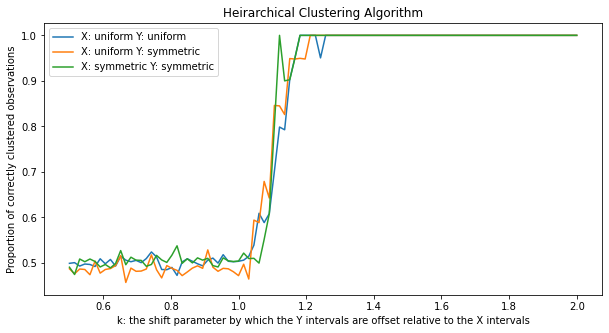

In [148]:
plt.plot(K, correct_k_XunifYunif, label="X: uniform Y: uniform")
plt.plot(K, correct_k_XunifYsym, label="X: uniform Y: symmetric")
plt.plot(K, correct_k_XsymYsym, label="X: symmetric Y: symmetric")
plt.legend()
plt.title("Heirarchical Clustering Algorithm")
plt.xlabel("k: the shift parameter by which the Y intervals are offset relative to the X intervals")
plt.ylabel("Proportion of correctly clustered observations")

Text(0, 0.5, 'Proportion of correctly clustered observations')

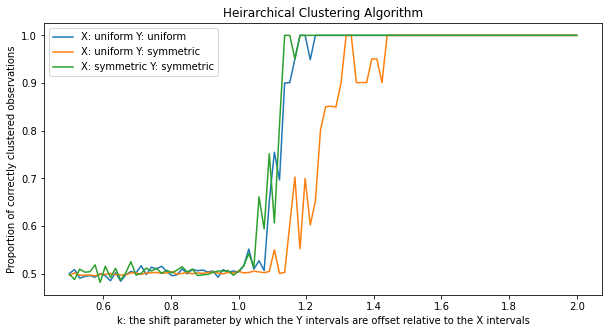

In [231]:
# Old clustering plot (based on erroneous distance calculation)
plt.plot(K, correct_k_XunifYunif, label="X: uniform Y: uniform")
plt.plot(K, correct_k_XunifYsym, label="X: uniform Y: symmetric")
plt.plot(K, correct_k_XsymYsym, label="X: symmetric Y: symmetric")
plt.legend()
plt.title("Heirarchical Clustering Algorithm")
plt.xlabel("k: the shift parameter by which the Y intervals are offset relative to the X intervals")
plt.ylabel("Proportion of correctly clustered observations")

## KMedoids Clustering

In [149]:
K = np.linspace(0.5, 2, 100, endpoint=True)
correct_k_XunifYunif = clustering_sim(K, scenario="XunifYunif", algorithm="KMedoids")
correct_k_XunifYsym = clustering_sim(K, scenario="XunifYsym", algorithm="KMedoids")
correct_k_XsymYsym = clustering_sim(K, scenario="XsymYsym", algorithm="KMedoids")

Text(0, 0.5, 'Proportion of correctly clustered observations')

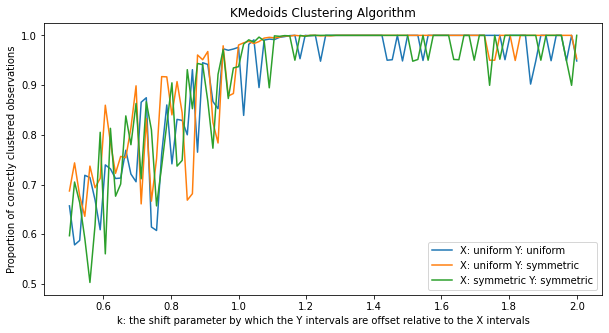

In [150]:
plt.plot(K, correct_k_XunifYunif, label="X: uniform Y: uniform")
plt.plot(K, correct_k_XunifYsym, label="X: uniform Y: symmetric")
plt.plot(K, correct_k_XsymYsym, label="X: symmetric Y: symmetric")
plt.legend()
plt.title("KMedoids Clustering Algorithm")
plt.xlabel("k: the shift parameter by which the Y intervals are offset relative to the X intervals")
plt.ylabel("Proportion of correctly clustered observations")

Text(0, 0.5, 'Proportion of correctly clustered observations')

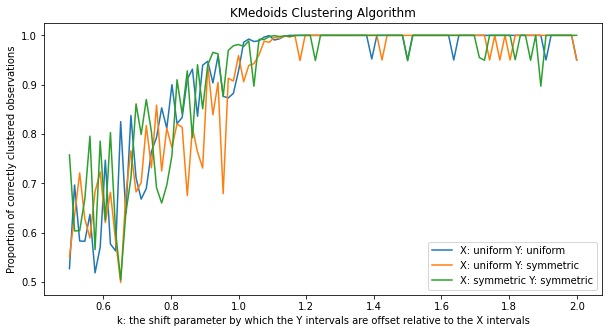

In [229]:
# Old plot based on erroneous distance calculations
plt.plot(K, correct_k_XunifYunif, label="X: uniform Y: uniform")
plt.plot(K, correct_k_XunifYsym, label="X: uniform Y: symmetric")
plt.plot(K, correct_k_XsymYsym, label="X: symmetric Y: symmetric")
plt.legend()
plt.title("KMedoids Clustering Algorithm")
plt.xlabel("k: the shift parameter by which the Y intervals are offset relative to the X intervals")
plt.ylabel("Proportion of correctly clustered observations")